# UIDAI Data Hackathon 2026

## Notebook 04
Anomaly Detection in Aadhaar Enrolment and Updates

### Objective
To detect unusual spikes, abnormal patterns, and potential systemic anomalies in Aadhaar enrolment and update data using statistical and machine learning techniques.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")


In [2]:
enrol_df = pd.read_csv("../data/enrolment_cleaned.csv")
demo_df = pd.read_csv("../data/demographic_updates_cleaned.csv")

print(enrol_df.shape, demo_df.shape)


(1006029, 7) (2071700, 6)


In [4]:
# Recreate total enrolment column (Notebook independence)
enrol_df['total_enrolment'] = (
    enrol_df['age_0_5'] +
    enrol_df['age_5_17'] +
    enrol_df['age_18_greater']
)

# Recreate total demo updates column (safety check)
demo_df['total_demo_updates'] = demo_df.drop(
    columns=['date', 'state', 'district', 'pincode'],
    errors='ignore'
).sum(axis=1)

print("Columns recreated successfully")


Columns recreated successfully


In [5]:
# Aggregate enrolment and updates at district level
district_enrol = (
    enrol_df
    .groupby(['state', 'district'])['total_enrolment']
    .sum()
    .reset_index()
)

district_updates = (
    demo_df
    .groupby(['state', 'district'])['total_demo_updates']
    .sum()
    .reset_index()
)

district_data = pd.merge(
    district_enrol,
    district_updates,
    on=['state', 'district'],
    how='inner'
)

district_data.head()


,state,district,total_enrolment,total_demo_updates
0,100000,100000,218,2
1,Andaman & Nicobar Islands,Andamans,75,750
2,Andaman & Nicobar Islands,Nicobars,1,4
3,Andaman & Nicobar Islands,South Andaman,38,305
4,Andaman And Nicobar Islands,Nicobar,75,787


In [6]:
# Select features for anomaly detection
features = district_data[['total_enrolment', 'total_demo_updates']]

# Train Isolation Forest
iso = IsolationForest(
    n_estimators=100,
    contamination=0.02,
    random_state=42
)

district_data['anomaly_flag'] = iso.fit_predict(features)

# -1 = anomaly, 1 = normal
district_data['anomaly_flag'].value_counts()


anomaly_flag
 1    988
-1     21
Name: count, dtype: int64

In [7]:
anomalies = district_data[district_data['anomaly_flag'] == -1]
anomalies.head(10)


,state,district,total_enrolment,total_demo_updates,anomaly_flag
125,Bihar,East Champaran,29323,248028,-1
143,Bihar,Patna,24644,243772,-1
155,Bihar,Sitamarhi,42232,169848,-1
159,Bihar,West Champaran,30438,233389,-1
217,Delhi,North West Delhi,16043,313989,-1
227,Gujarat,Ahmedabad,19130,267884,-1
258,Gujarat,Surat,25469,357582,-1
379,Karnataka,Bengaluru,30980,303924,-1
536,Maharashtra,Nashik,22368,246100,-1
540,Maharashtra,Pune,31763,438478,-1


In [8]:
district_data.describe()


,total_enrolment,total_demo_updates,anomaly_flag
count,1009.000000,1009.000000,1009.000000
mean,5299.976214,48853.616452,0.958375
std,6570.971278,61051.628113,0.285655
min,1.000000,1.000000,-1.000000
25%,588.000000,4239.000000,1.000000
50%,2957.000000,28534.000000,1.000000
75%,7242.000000,68123.000000,1.000000
max,43688.000000,447253.000000,1.000000


In [9]:
features = district_data[['total_enrolment', 'total_demo_updates']]


In [10]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=150,
    contamination=0.02,   # 2% anomalies (realistic for govt data)
    random_state=42
)

district_data['anomaly_flag'] = iso.fit_predict(features)


In [11]:
district_data['anomaly_flag'].value_counts()


anomaly_flag
 1    988
-1     21
Name: count, dtype: int64

In [12]:
anomalies = district_data[district_data['anomaly_flag'] == -1]

anomalies.sort_values(
    by=['total_enrolment', 'total_demo_updates'],
    ascending=False
).head(15)


,state,district,total_enrolment,total_demo_updates,anomaly_flag
549,Maharashtra,Thane,43688,447253,-1
155,Bihar,Sitamarhi,42232,169848,-1
872,Uttar Pradesh,Bahraich,39338,129697,-1
990,West Bengal,Murshidabad,35911,371953,-1
1002,West Bengal,South 24 Parganas,33542,401187,-1
540,Maharashtra,Pune,31763,438478,-1
737,Rajasthan,Jaipur,31146,275340,-1
379,Karnataka,Bengaluru,30980,303924,-1
159,Bihar,West Champaran,30438,233389,-1
125,Bihar,East Champaran,29323,248028,-1


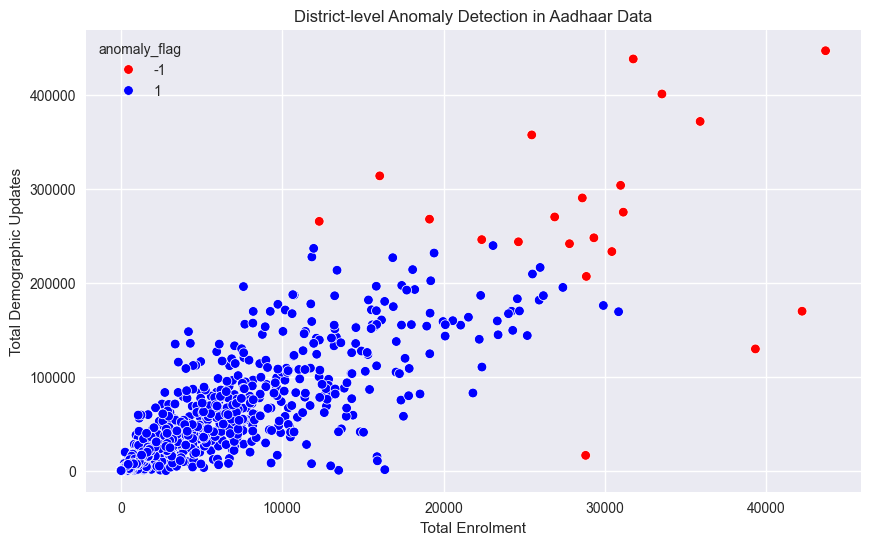

In [13]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=district_data,
    x='total_enrolment',
    y='total_demo_updates',
    hue='anomaly_flag',
    palette={1: 'blue', -1: 'red'}
)

plt.title("District-level Anomaly Detection in Aadhaar Data")
plt.xlabel("Total Enrolment")
plt.ylabel("Total Demographic Updates")
plt.show()


In [14]:
anomalies = district_data[district_data['anomaly_flag'] == -1]
anomalies[['state', 'district', 'total_enrolment', 'total_demo_updates']].head(10)


,state,district,total_enrolment,total_demo_updates
125,Bihar,East Champaran,29323,248028
139,Bihar,Muzaffarpur,28855,206917
143,Bihar,Patna,24644,243772
155,Bihar,Sitamarhi,42232,169848
159,Bihar,West Champaran,30438,233389
217,Delhi,North West Delhi,16043,313989
227,Gujarat,Ahmedabad,19130,267884
258,Gujarat,Surat,25469,357582
379,Karnataka,Bengaluru,30980,303924
536,Maharashtra,Nashik,22368,246100


In [15]:
anomalies.to_csv("../final_report/anomalous_districts.csv", index=False)


Conclusion

Using machine learning–based anomaly detection, we identified districts with irregular Aadhaar update patterns. These anomalies can help UIDAI prioritize audits, improve data quality, and enhance operational monitoring.